In [1]:
import os
DISABLE_KEYS = """#TF_ADJUST_HUE_FUSED
#TF_AUTOTUNE_THRESHOLD
TF_ENABLE_AUTO_MIXED_PRECISION
TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT
#TF_XLA_FLAGS
#TF_ADJUST_SATURATION_FUSED
#TF_ENABLE_WINOGRAD_NONFUSED""".split('\n')
for k in os.environ:
    if k in DISABLE_KEYS:
        print(k)
        del os.environ[k]

TF_ENABLE_AUTO_MIXED_PRECISION
TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT


In [2]:
import glob
from pathlib import Path
sample_images = [str(p) for p in Path("sample_images").glob("*")]
sample_images

['sample_images/習近平.jpg',
 'sample_images/川普.jpg',
 'sample_images/阿爾登.jpg',
 'sample_images/柯文哲.jpg',
 'sample_images/譚德塞.jpg',
 'sample_images/伊莉莎白二.jpg',
 'sample_images/韓國瑜.jpg',
 'sample_images/蔡英文.jpg']

## Face alignment

In [3]:
import os
import sys
import bz2
from tensorflow.keras.utils import get_file
from ffhq_dataset.face_alignment import image_align
from ffhq_dataset.landmarks_detector import LandmarksDetector

In [4]:
LANDMARKS_DATA_FILENAME = "shape_predictor_68_face_landmarks.dat"
LANDMARKS_MODEL_URL = f'http://dlib.net/files/{LANDMARKS_DATA_FILENAME}.bz2'
if not Path(LANDMARKS_DATA_FILENAME).exists():
    data_bz = get_file(f'{LANDMARKS_DATA_FILENAME}.bz2', 
                                               LANDMARKS_MODEL_URL, cache_subdir='temp')
    with open(LANDMARKS_DATA_FILENAME, 'bw') as f: 
        f.write(bz2.open(data_bz).read())
landmarks_detector = LandmarksDetector(LANDMARKS_DATA_FILENAME)

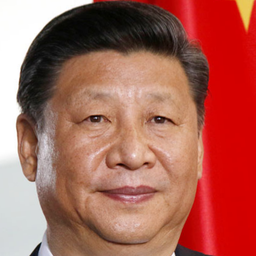

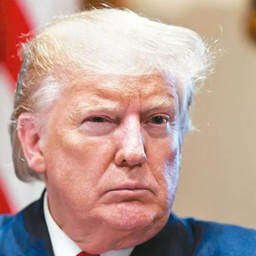

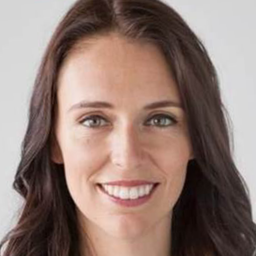

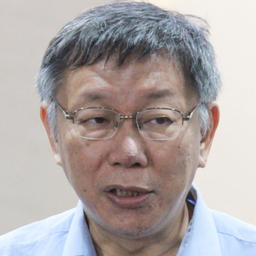

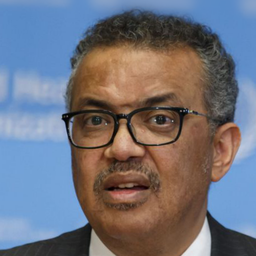

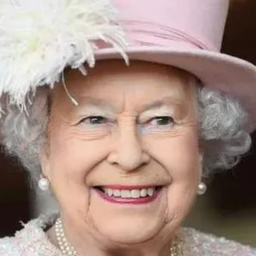

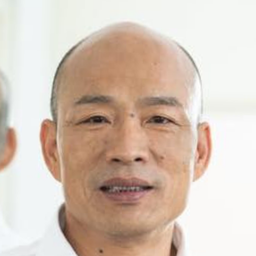

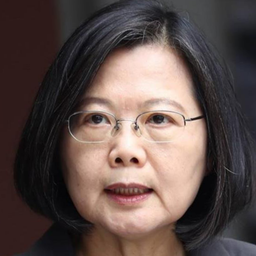

In [5]:
from PIL import Image
from IPython.display import display, clear_output
aligned_faces = []
for unaligned_img_fn in sample_images:
    for face_landmarks in landmarks_detector.get_landmarks(unaligned_img_fn):
        aligned_img = image_align(unaligned_img_fn, face_landmarks)
        aligned_faces.append(aligned_img)
        display(aligned_img.resize((256,256), Image.LANCZOS))

## Project Images

In [6]:
import os
import numpy as np

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks
import projector
from training import dataset
from training import misc

### Set up the projector

In [7]:
_G, _D, Gs = pretrained_networks.load_networks('gdrive:networks/stylegan2-ffhq-config-f.pkl')

# vgg16_pkl url: https://drive.google.com/uc?id=1N2-m9qszOeVC9Tq77WxsLnuWwOedQiD2
proj = projector.Projector(
    vgg16_pkl             = './vgg16_zhang_perceptual.pkl',
    num_steps             = 300,
    initial_learning_rate = 0.1,
    initial_noise_factor  = 0.05,
    verbose               = True
)

proj.set_network(Gs)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Projector: Finding W midpoint and stddev using 10000 samples...
Projector: std = 42.4506
Projector: Setting up noise inputs...
Projector: G_synthesis/noise0 <tf.Variable 'G_synthesis_2/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>
Projector: G_synthesis/noise1 <tf.Variable 'G_synthesis_2/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise2 <tf.Variable 'G_synthesis_2/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise3 <tf.Variable 'G_synthesis_2/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise4 <tf.Variable 'G_synthesis_2/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise5 <tf.Variable 'G_synthesis_2/noise5:0' shape=(1, 1, 32, 32) dtype=float32_ref>
Projector: G_synthesis/noise6 <tf.Variable 'G_synthesis_2/noise6:0'

### Find latent code

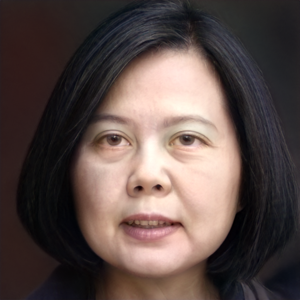

In [8]:
results = []
for target_face in aligned_faces:
    # convert Image to np array
    images = np.transpose(np.array(target_face), [2,0,1])[None, ...]
    images = misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    proj.start(images)
    while proj.get_cur_step() < proj.num_steps:
        print('%d / %d ... ' % (proj.get_cur_step(), proj.num_steps))
        proj.step()
        clear_output(True)
        img = np.transpose(proj.get_images()[0], [1,2,0])
        img = ((img+1)*127.5).clip(0, 255).astype('uint8')
        display(Image.fromarray(img).resize((300,300)))
    results.append((img, proj.get_dlatents()))

### Generate

In [10]:
Gs_syn_kwargs = dnnlib.EasyDict(output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
                               randomize_noise = False,
                               minibatch_size = 4)

In [11]:
# Use above generated dlatents
# dlatents = np.concatenate([r[1] for r in results], axis=0)
# Use precalculated dlatents
dlatent_saved_files = Path('project_images/').glob('*.npy')
dlatents = np.array([np.load(f) for f in dlatent_saved_files])
dlatents.shape

(8, 18, 512)

In [12]:
all_images = Gs.components.synthesis.run(dlatents, **Gs_syn_kwargs)
all_images.shape

(8, 1024, 1024, 3)

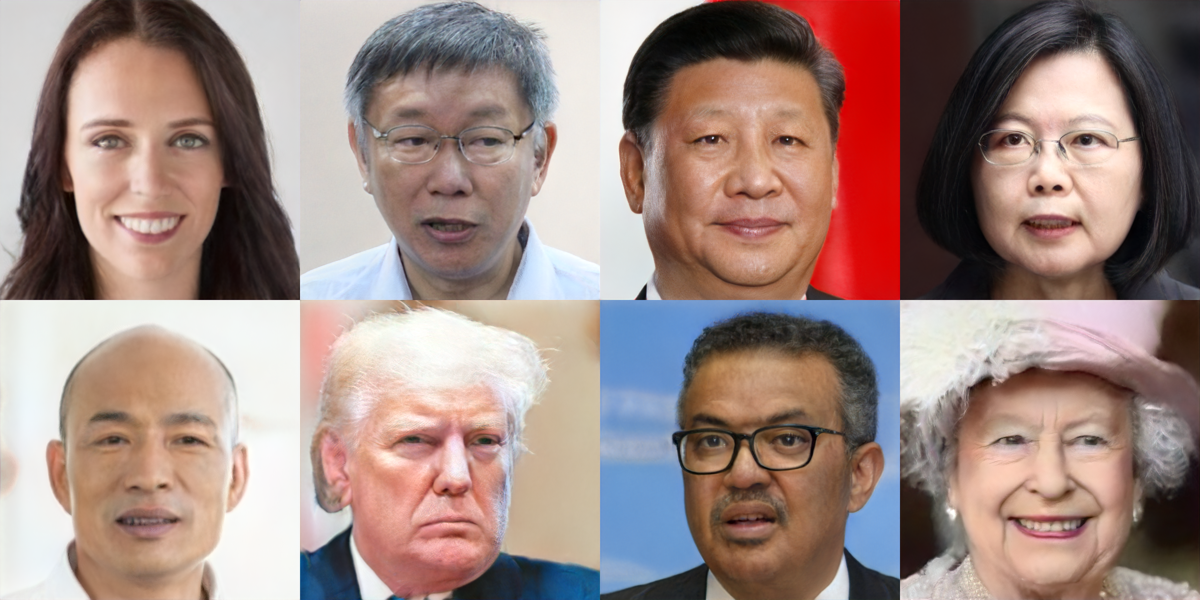

In [13]:
img = all_images.reshape((2,4, 1024, 1024, 3))
img = np.transpose(img, [0,2,1,3,4]).reshape((2*1024, 4*1024, 3))
img = Image.fromarray(img)
img = img.resize((4*300, 2*300))
img

### Style Mixing

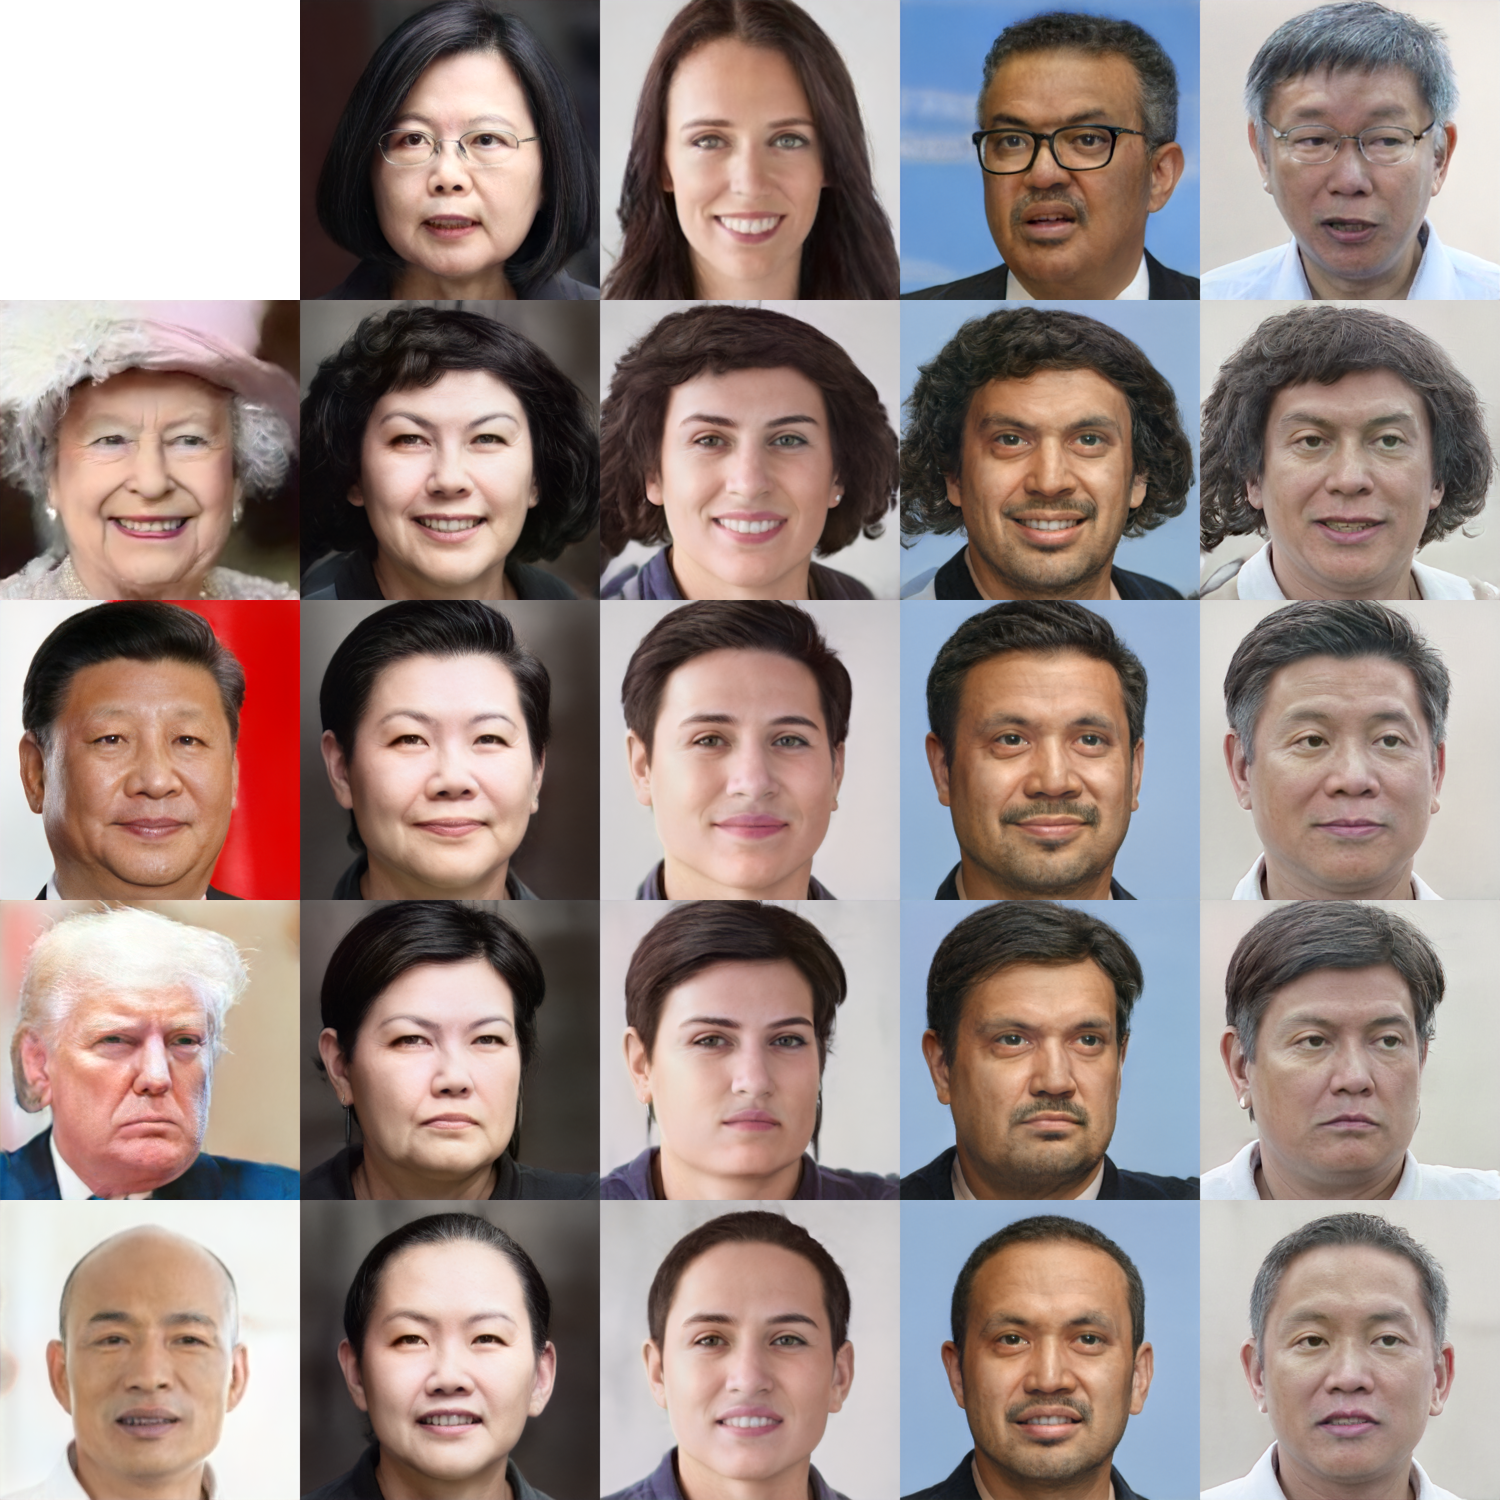

In [14]:
np.random.shuffle(dlatents)
CONTENT_FEATURES = range(0, 5)
N_STYLES = 4
N_CONTENTS = 4
IMG_W, IMG_H = 300, 300
truncation_psi = 1.0

style_dlatents = dlatents[:N_STYLES]
content_dlatents = dlatents[-N_CONTENTS:]
canvas = Image.new('RGB', (IMG_W*(N_STYLES+1), IMG_H*(N_CONTENTS+1)), 'white') 
dlatent_avg = Gs.get_var('dlatent_avg')
for i in range(-1, N_STYLES):
    row_dlatents = style_dlatents.copy()
    if i>=0:
        content_dlatent = content_dlatents[i]
        row_dlatents[:, CONTENT_FEATURES] = content_dlatent[CONTENT_FEATURES]
        # truncation
        row_dlatents = dlatent_avg + (row_dlatents-dlatent_avg).clip(-truncation_psi, truncation_psi)
        # concat content and mixed images
        row_dlatents = np.concatenate([content_dlatent[None, ...], row_dlatents], axis=0)

    row_images = Gs.components.synthesis.run(row_dlatents, **Gs_syn_kwargs)
    n_imgs = row_images.shape[0]
    img = np.transpose(row_images, [1,0,2,3]).reshape((1024, -1, 3))
    img = Image.fromarray(img).resize((IMG_W*n_imgs, IMG_H))
    canvas.paste(img, ( IMG_W*(N_STYLES-n_imgs+1) , IMG_H*(i+1)))
display(canvas)
    

## Cat, and other interesting faces

In [15]:
def projection(proj, target_face):
    proj.num_steps = 1000
    # convert Image to np array
    images = np.transpose(np.array(target_face), [2,0,1])[None, ...]
    images = misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    proj.start(images)
    while proj.get_cur_step() < proj.num_steps:
        print('%d / %d ... ' % (proj.get_cur_step(), proj.num_steps))
        proj.step()
        clear_output(True)
        img = np.transpose(proj.get_images()[0], [1,2,0])
        img = ((img+1)*127.5).clip(0, 255).astype('uint8')
        display(Image.fromarray(img).resize((300,300)))

In [16]:
#dlatents = np.concatenate([proj.get_dlatents(), dlatents], axis=0)

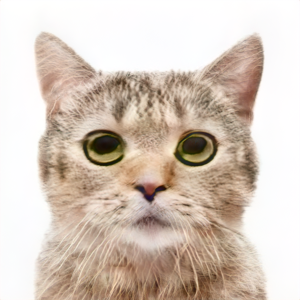

In [17]:
# Cat
# https://static.toiimg.com/thumb/msid-67586673,width-800,height-600,resizemode-75,imgsize-3918697,pt-32,y_pad-40/67586673.jpg
cat_face  = Image.open('other_images/cat.png').crop((190,10, 635,455))
cat_face = cat_face.resize((1024,1024), Image.BILINEAR)
projection(proj, cat_face)

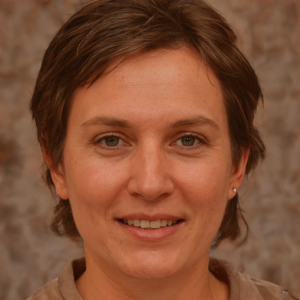

In [ ]:
# https://media-mbst-pub-ue1.s3.amazonaws.com/creatr-uploaded-images/2019-10/a94b5a40-f328-11e9-98d9-6cc2a9452544
target_face = Image.open('other_images/炎柱.jpg').crop((470,80,790,400))
target_face = target_face.resize((1024,1024), Image.BILINEAR)
projection(proj, target_face)

In [ ]:
# https://c-ssl.duitang.com/uploads/item/201605/23/20160523184740_ATtux.thumb.700_0.jpeg
unaligned_img_fn = '20160523184740_ATtux.thumb.700_0.jpeg'
for face_landmarks in landmarks_detector.get_landmarks(unaligned_img_fn):
        target_face = image_align(unaligned_img_fn, face_landmarks)
        display(target_face.resize((256,256), Image.LANCZOS))

In [ ]:
projection(proj, target_face)

In [ ]:
# https://i.insider.com/5dbc6da7e94e8670d35b0a6e?width=1600&format=jpeg&auto=webp
unaligned_img_fn = 'joker.jpg'
for face_landmarks in landmarks_detector.get_landmarks(unaligned_img_fn):
        target_face = image_align(unaligned_img_fn, face_landmarks)
        display(target_face.resize((256,256), Image.LANCZOS))

In [ ]:
projection(proj, target_face)